In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  torch.distributions import normal , MultivariateNormal
# import Calibration/GPE_ensemble as GPE

dtype = torch.float
device = torch.device("cpu")

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import 
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion


%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize
from scipy.stats import norm

import sys
#sys.path.append(os.path.join('Calibration'))
import GPE_ensemble as GPE

#pip install emcee

import emcee

# Observational model: $y=h(\theta)+\epsilon$  

For some data, $x$, and observations, $y$, we believe the following model applies:

$y=h(\theta)+\epsilon$

Then we can write the conditional distribution 

$z|\theta \sim N(h(\theta),\sigma_e^2)$

where z is a realization of y

If our prior over $x$ is also normal, i.e.

$\theta \sim N(\mu_0,\sigma_0^2)$

Then the true posterior (when $h(\theta)$ is $b \theta$) is:

$\theta|z \sim N(\mu_p,\sigma_p^2)$

where

$\mu_p = \frac{\sigma_0^2bz+\sigma_e^2\mu_0}{\sigma_0^2b^2+\sigma_e^2}$

and

$\sigma_p^2 = \frac{2\sigma_0^2\sigma_e^2}{\sigma_0^2b^2+\sigma_e^2}$

We will use this true posterior to compare to our MCMC results


The true posterior mean and variance when multiple (M) measurements $[Z_i]_{i=1}^M$ are available (b=1):

$\mu_p = \frac{\frac{\left(\sum_{i=1}^M Z_i \right)/M}{\sigma_e^2/M} + \frac{\mu_0}{\sigma_0^2  }}{\frac{1}{\sigma_e^2/M} + \frac{1}{\sigma_0^2  }}$

$\sigma_p^2 = \frac{1}{\frac{1}{\sigma_e^2/M} + \frac{1}{\sigma_0^2  }}$

# Metropolis-Hastings algorithm
1. Start the chain at $\theta_0$ and choose a prior for $\theta= p_0(\theta)$ and a MCMC proposal variance sigma2_mc

For $i \in[1,N]$, where $N$ is the desired chain length

2. Propose $\theta_i$ based on random walk, i.e. $ \theta_i=\theta_{i-1}+\text{sigma2_mc}*\mathcal{N}(0,1) $
3. Calculate probability of acceptance: $\alpha = \frac{P(\theta_{i})}{P_{\theta_{i-1}}}$

where $P(\theta)$ is the posterior s.t. $P(\theta) = p_0(\theta)* \Pi_{j=1}^M p(Z_j|\theta)$, for M measurements

4. Accept $\theta_i$ with probability $\alpha$
5. Append the chain with $\theta_i$ if accepted else with $\theta_{i-1}$ 



In [2]:
# Used without emulator
def acceptance_mult(y,x,x_prime,hx,hx_prime,sigma2): # Log acceptance probabilty (for stability)
    tmp_num = (-0.5*(1/sigma2)*(hx_prime-y)**2)
    tmp_den = (-0.5*(1/sigma2)*(hx-y)**2)
    ratio =( -(0.5)*x_prime**2 + tmp_num.sum()) - (-(0.5)*x**2 + tmp_den.sum())
    alpha = np.min((0,ratio))
    return alpha


def metrop_h(y_cal,x0,sigma2_mc,sigma2_e,fun_g,case,iters):
    chain = np.zeros(iters+1) #Initialise markov chain
    chain[0]=x0 #set x0 as first element
    acc=0
    for i in range(iters):
        x = chain[i] #define x
        x_p = np.random.normal(chain[i],sigma2_mc) #select candidate value x'
        hx = fun_g(x,case)
        hx_p = fun_g(x_p,case)
        alpha = acceptance_mult(y_cal,x,x_p,hx,hx_p,sigma2_e) #calculate probability of acceptance
        u=np.random.uniform() #generate random uniform variable
        if np.log(u)<alpha: 
            chain[i+1]=x_p #accept candidate value
            acc+=1
        else:
            chain[i+1]=x #reject candidate value
            
    print("acceptance rate=", acc/iters*100,"%" )
    
    return chain


In [3]:
# Used with emulator
def log_prior(theta): #N(0,1) log pdf as the prior
    lp = -(0.5)*theta**2
    return lp

def log_likelihood(y,theta,sigma2_e,fun_g,case): #Log likelihood up to proportionality
    ll = -(0.5/(sigma2_e))*(fun_g(theta,case)-y)**2- 0.5*np.log(torch.tensor(2*torch.pi))-0.5*np.log(sigma2_e)
    return ll
    
def log_prob(theta,y,sigma2_e): # Log probability (prior x likelihood)
    
    lp = log_prior(theta)
    ll =log_likelihood(y,theta,sigma2_e,fun_g,case)
    return lp + ll


def log_likelihood_emulator(y,theta,sigma2_e,emulator):
    y=torch.tensor([y])[:,None]
    theta=torch.tensor(theta)[:,None]
    sigma2_e=torch.tensor([sigma2_e])[:,None]
    ll = emulator.ensemble_log_likelihood_obs_error(theta,y,sigma2_e).detach().numpy()
    return ll
    
# def log_prob_emulator(theta,y,sigma2_e,emulator):
    
#     lp = log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     ll =log_likelihood_emulator(y,theta,sigma2_e,emulator)
#     return lp + ll


def log_prob_emulator_mult(theta,y,sigma2_e,emulator):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll=0
    for i in range(y.shape[0]):
        tmp_ll=log_likelihood_emulator(y[i],theta,sigma2_e,emulator)
        ll+=tmp_ll
    return lp + ll

In [4]:
# Returns MCMC chain (with or without emulator) after burn in and also after thinning if used with emulator
def calibrate_MCMC(Z,n_obs,fun_h,emulator,num_steps,case,iters,nwalkers,ndim,log_prob_emulator_mult,sigma2_e,sigma2_mc,burn_in,thin,use_emulator):
    if n_obs>1:
        use_obs = num_steps
    else:
        use_obs = n_obs
    
    if use_emulator:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_emulator_mult, args=[Z[0:use_obs],sigma2_e,emulator])
        sampler.run_mcmc(p0[:,None], iters) # Run sampler
        # Flatten walkers, discard burn in, thin the samples by 10
        X_mcmc = sampler.get_chain(discard=burn_in, thin=10, flat=True) # flat=True 
    else:
        X = metrop_h(Z[0:use_obs],x0,sigma2_mc,sigma2_e,fun_h,case,iters)
        X_mcmc = X[burn_in::]
    
    return X_mcmc
    

# Define the observation function

In [32]:
mult=1

In [33]:
def fun_h(x,case): 
    if case == 'linear':
        fun = x
    elif case == 'non-linear':
        fun = 2*(x+x**2+x**3)*mult
#         fun = np.exp(x)+np.exp(-x**2)
    else:
        print('invalid case, input linear or non-linear')
    return fun


# Pseudo-code for EnKF for a static (toy) problem

1. Assume a true set of parameter(s) $\theta^*$, without any loss of generality, let $\theta^* \in \mathbb{R} $, and  $h(\theta^*) \in \mathbb{R}$

There is an option to choose $h(.)$ as linear or non-linear by setting the variable 'case' accordingly.

2. Generate an artificial observation as follows $Z=h(\theta^*)+\mathcal{N}(0,\sigma_e^2)$
3. Sample the parameters  $[\hat{\theta}_{t_0}^j]_{j=1}^N $ from an initial distribution - presently taken as $\mathcal{N}(0,1)$ - for the filtering algorithm (equivalent to the prior distribution in MCMC)
4. Propose $\theta$ for the next (pseudo) time step based on Euler-Maruyama integration for $dB_t$ for every ensemble member $j \in [1,N]$ as follows
$$ \theta^j_{t+1} = \hat{\theta}^j_t + \sigma_{\theta} \Delta B^j_t$$ 
where $\Delta B^j_t \sim \mathcal{N}(0,\Delta t)$ and $\sigma_{\theta}$ is the process noise intensity which is typically around $0.1$ 

5. Update the ensemble based on the Kalman gain matrix 
$$ \hat{\theta}^j_{t+1} =  \theta^j_{t+1} + K_{t+1} [(Z+noise^j_{t+1}) - h(\theta^j_{t+1})]$$
where $noise^j_{t+1}$ is sampled from $\mathcal{N}(0,\sigma_e^2 * num\_steps)$ and $K_{t+1}$ is the Kalman gain matrix (function of the ensembles of $\theta_{t+1}$ and $h(\theta_{t+1})$ as well as $\sigma_e$) calculated as follows:



$$ K_{t+1} = P_f Y_f^T [Y_f Y_f^T + R] ^{-1}$$ 
where $R$ is the (scaled) measurement variance: $R=\sigma_e^2 * num\_steps$ 
$$P_f = \frac{[ \theta^j_{t+1} - \bar{\theta}_{t+1} ]_{1 \times N}}{\sqrt{N-1}} \;\;\; ; \;\;\; \bar{\theta}_{t+1} \textrm{ is the mean of} \;\;[\theta^j_{t+1}]_{j=1}^N $$ 
$$ Yf =\frac{ [h(\theta^j_{t+1}) - \bar{ h(\theta_{t+1})} ]_{1 \times N}}{\sqrt{N-1}} \;\;\; ; \;\;\;  \bar{ h(\theta_{t+1})} \textrm{ is the mean of} \;\; [h(\theta^j_{t+1}) ]_{j=1}^N $$  

For $h(\theta_t)$, there is an option to directly evaluate the function $h(.)$ itself or its emulator mean by setting the variable 'use_emulator' to True or False

6. Repeat steps 4 and 5 until a certain convergence criteria for $\theta$ is met (presently, the number of iterations '$num\_steps$' is decided beforehand to enable the scaling of measurement noise accordingly)


# Remarks

1.If the measurements are taken several times by repeating the experiment, then these may be treated as pseudo-time history of measurements, and may be used one at a time at every iteration of the algorithm. Note, this is different than having a vector of observations where several quantities may be measured in one experiment.

2.For the modified Mitchell Schaeffer calibration problem, $\theta \in \mathcal{R}^5$ if calibrating all 5 tissue parameters,  and $h(\theta) \in \mathcal{R}^M$ where $M$ is the number of locations where LAT measurements are available. Then $P_f, Y_f$ are matrices of size $5 \times N$ and $M \times N$ respectively, so that $K$ is  $d \times 1$. $\sigma_e$ values need not be the same at all locations.


In [34]:
# Returns the (pseudo-)time history of mean and variance (X_s, X_s_std) and the ensemble at the last step
def calibrate_EnKF(Y,n_obs,sigma2_e,fun_g,emulator,N,num_steps,X_init,case,use_emulator):    
    import numpy as np
    import matplotlib.pyplot as plt

    if n_obs>1:
        num_steps = n_obs
    
    sig_meas = np.sqrt(sigma2_e)*np.sqrt(num_steps) #measurement noise intensity (scaled by #iterations)
    meas = Y 
    sig_theta =0.1 #process noise intensity
    dt=0.01 #time step
    
    sig_dt = sig_theta*np.sqrt(dt) # std deviation for the noise in process
    
    X = X_init
    X1 = np.zeros((1,N))
    X2 = np.zeros((1,N))
    X_s = np.zeros((1,num_steps))
    X_s[:,0] = np.mean(X,axis=1)
    X_s_std = np.zeros((1,num_steps))
    X_s_std[:,0] = np.std(X,axis=1)

    for t in range(1,num_steps):
        X1 = X+np.random.normal(0,sig_dt, size=(1,N))
        if use_emulator:
            hX1 = (emulator.predict(torch.from_numpy(X.T)).T).detach().numpy()
        else:
            hX1 = fun_g(X,case)
            
        X1_mean = np.mean(X1,axis=1)
        Pf =( X1 - np.repeat(X1_mean[:,np.newaxis],N,axis=1))/np.sqrt(N-1)
        hX1 = np.reshape(hX1,(1,N))  #  hX1 = hX1.T
        hX1_mean = np.mean(hX1)
        Yf = ( hX1 - hX1_mean*np.ones_like(hX1))/np.sqrt(N-1)
        Siinv = 1./(Yf@Yf.T+sig_meas**2) 
        K = Pf@Yf.T*Siinv
        if n_obs==1: 
            X2 = X1 + K@(meas[0,0]+np.random.normal(0,sig_meas,size=(1,N))-hX1)
        else:
            X2 = X1 + K@(meas[t-1,0]+np.random.normal(0,sig_meas,size=(1,N))-hX1)
        X_s[:,t]=np.mean(X2,axis = 1)
        X_s_std[:,t]=np.std(X2,axis=1)
        X = X2.copy()

    return X_s,X_s_std**2, X


# Pseudo-code for the new EnKF without process dynamics
1. Assume a true set of parameter(s) $\theta^*$, without any loss of generality, let $\theta^* \in \mathbb{R} $, and  $h(\theta^*) \in \mathbb{R}$

There is an option to choose $h(.)$ as linear or non-linear by setting the variable 'case' accordingly.

2. Generate an artificial observation as follows $Z=h(\theta^*)+\mathcal{N}(0,\sigma_e^2)$
3. Sample the parameters  $[\hat{\theta}_{t_0}^j]_{j=1}^N $ from an initial distribution - presently taken as $\mathcal{N}(0,1)$ - for the filtering algorithm (equivalent to the prior distribution in MCMC)


5. Update the ensemble based on the Kalman gain matrix 
$$ \hat{\theta}^j_{t+1} =  \hat{\theta}^j_{t} + K_{t} [(Z+noise^j_{t}) - h(\hat{\theta}^j_{t})]$$
where $noise^j_{t}$ is sampled from $\mathcal{N}(0,\sigma_e^2 * num\_steps)$ and $K_{t}$ is the Kalman gain matrix (function of the ensembles of $\theta_{t}$ and $h(\theta_{t})$ as well as $\sigma_e$) calculated as follows:



$$ K_{t} = P_f Y_f^T [Y_f Y_f^T + R] ^{-1}$$ 
where $R$ is the (scaled) measurement variance: $R=\sigma_e^2 * num\_steps$ 
$$P_f = \frac{[ \hat{\theta}^j_{t} - \bar{\hat{\theta}}_{t} ]_{1 \times N}}{\sqrt{N-1}} \;\;\; ; \;\;\; \bar{\hat{\theta}}_{t} \textrm{ is the mean of} \;\;[\hat{\theta}^j_{t}]_{j=1}^N $$ 
$$ Yf =\frac{ [h( \hat{\theta}^j_{t} ) - \bar{ h(\hat{\theta}_{t})} ]_{1 \times N}}{\sqrt{N-1}} \;\;\; ; \;\;\;   \bar{ h(\hat{\theta}_{t})} \textrm{ is the mean of} \;\; [h( \hat{\theta}^j_{t} )]_{j=1}^N $$  


For $h(\theta_t)$, there is an option to directly evaluate the function $h(.)$ itself or its emulator mean by setting the variable 'use_emulator' to True or False

5. Repeat steps 4 and 5 until a certain convergence criteria for $\theta$ is met (presently, the number of iterations '$num\_steps$' is decided beforehand to enable the scaling of measurement noise accordingly)

In [35]:
# Returns the (pseudo-)time history of mean and variance (X_s, X_s_std) and the ensemble at the last step
def calibrate_new_EnKF(Y,n_obs,sigma2_e,fun_g,emulator,N,num_steps,X_init,case,use_emulator): 
    import numpy as np
    import matplotlib.pyplot as plt
    
    if n_obs>1:
        num_steps = n_obs

    sig_meas = np.sqrt(sigma2_e)*np.sqrt(num_steps) #measurement noise intensity (scaled by #iterations)
    meas = Y 
    
    X = X_init
    X2 = np.zeros((1,N))
    X_s = np.zeros((1,num_steps))
    X_s[:,0] = np.mean(X,axis=1)
    X_s_std = np.zeros((1,num_steps))
    X_s_std[:,0] = np.std(X,axis=1)
    for t in range(1,num_steps):
        if use_emulator:
            hX = (emulator.predict(torch.from_numpy(X.T)).T).detach().numpy()
        else:
            hX = fun_g(X,case)
            
        X_mean = np.mean(X,axis=1)
        Pf =( X - np.repeat(X_mean[:,np.newaxis],N,axis=1))/np.sqrt(N-1)
        hX_mean = np.mean(hX)
        Yf = ( hX - hX_mean*np.ones_like(hX))/np.sqrt(N-1)
        Siinv = 1./(Yf@Yf.T+sig_meas**2) 
        K = Pf@Yf.T*Siinv
        if n_obs==1: 
            X2 = X + K@(meas[0,0]+np.random.normal(0,sig_meas,size=(1,N))-hX)
        else:
            X2 = X + K@(meas[t-1,0]+np.random.normal(0,sig_meas,size=(1,N))-hX)

        X_s[:,t]=np.mean(X2,axis = 1)
        X_s_std[:,t]=np.std(X2,axis=1)
        X = X2.copy()

    return X_s,X_s_std**2, X


# Ensemble Kalman inversion (EKI) 

As per Section 2.3 of Iglesias et.al. 2013 upto a scaling of the measurement noise variance by the number of iterations $num\_steps$

In [36]:
# Returns the (pseudo-)time history of mean and variance (X_s, X_s_std) and the ensemble at the last step
def calibrate_EKI(Y,n_obs,sigma2_e,fun_g,emulator,N,num_steps,X_init,case,use_emulator):
    import numpy as np
    import matplotlib.pyplot as plt

    if n_obs>1:
        num_steps = n_obs

    sig_meas = np.sqrt(sigma2_e)*np.sqrt(num_steps)
    meas = Y 
    
    X = X_init

    if use_emulator:
        hX = (emulator.predict(torch.from_numpy(X.T)).T).detach().numpy()
    else:
        hX = fun_g(X,case)
 
    Z = np.concatenate((X,hX),axis=0)
    Z1 = np.zeros((2,N))
    Z2 = np.zeros((2,N))
   
    X_s = np.zeros((2,num_steps))
    X_s[:,0] = np.mean(Z,axis=1)
    X_s_std = np.zeros((2,num_steps))
    X_s_std[:,0] = np.std(Z,axis=1)

    for t in range(1,num_steps):
        Z1[0,:] = Z[0,:]

        if use_emulator:
            Z1[1,:] = (emulator.predict(torch.from_numpy(Z[0,:].T)).T).detach().numpy()
        else:
            Z1[1,:] = fun_g(Z[0,:],case)

        Z1_mean = np.mean(Z1,axis=1)
        tmp_C1 = ( Z1 - np.repeat(Z1_mean[:,np.newaxis],N,axis=1) )
        C1 = np.cov(tmp_C1)
        H = np.array([0,1])
        Siinv = 1./(H.T@C1@H+sig_meas**2) 
        K = C1@H*Siinv
        if n_obs ==1: 
            Z2 = Z1 + K[:,np.newaxis]*(meas[0,0]+np.random.normal(0,sig_meas,size=(1,N))-Z1[1,:]) #perturbed obs
        else: 
            Z2 = Z1 + K[:,np.newaxis]*(meas[t-1,0]+np.random.normal(0,sig_meas,size=(1,N))- Z1[1,:]) 
        
        X_s[:,t]=np.mean(Z2,axis = 1)
        X_s_std[:,t]=np.std(Z2,axis=1)
        Z=Z2.copy()

    return X_s,X_s_std**2, X


In [37]:
def plot_all_methods(X_mean,X_var,X2_mean,X2_var,X3_mean,X3_var,X,fig,ax,i,table_mean, table_var,true_theta):
    ############### EnKF ###############
    # Parameters of the normal distribution
    mean = X_mean[0,-1]  # Mean of the distribution
    variance = X_var[0,-1]  # Variance of the distribution

    # Generate x values
    x = np.linspace( mean - 4 * np.sqrt(variance), mean + 4 * np.sqrt(variance), 1000)
    # Calculate the PDF values for the normal distribution
    pdf_values = norm.pdf(x, loc= mean, scale=np.sqrt(variance))

    ############## new EnKF ###############

    mean2 = X2_mean[0,-1]  # Mean of the distribution
    variance2 = X2_var[0,-1]  # Variance of the distribution
    x2 = np.linspace( mean2 - 4 * np.sqrt(variance2), mean2 + 4 * np.sqrt(variance2), 1000)
    pdf_values2 = norm.pdf(x2, loc= mean2, scale=np.sqrt(variance2))

    ############## EKI ###############
    mean3 = X3_mean[0,-1] 
    variance3 = X3_var[0,-1] 
    x3 = np.linspace( mean3 - 4 * np.sqrt(variance3), mean3 + 4 * np.sqrt(variance3), 1000)
    pdf_values3 = norm.pdf(x3, loc= mean3, scale=np.sqrt(variance3))

    ax[i,0].plot(x,  pdf_values, label='EnKF',linestyle = 'dotted')
    ax[i,0].plot(x2, pdf_values2,label='new EnKF',linestyle = 'dotted')
    ax[i,0].plot(x3, pdf_values3,label='EKI',linestyle = 'dotted')
    ax[i,0].hist(X,density=True, label = 'MCMC', bins=50)
    ax[i,0].axvline(x=true_theta, linestyle='--',label = 'True parameter',color = 'purple')
    ax[i,0].legend(fontsize=6)  

    ax[i,1].plot(X_mean[0,:], label= 'EnKF')
    ax[i,1].plot(X2_mean[0,:], label = 'new EnKF')
    ax[i,1].plot(X3_mean[0,:], label = 'EKI')
    ax[i,1].hlines(y=true_theta, xmin=0, xmax=X_mean.shape[1], colors='r', linestyles='dashed', label = 'Reference')

    ax[i,1].legend()
    
    ax[i,2].plot(X_var[0,:], label= 'EnKF')
    ax[i,2].plot(X2_var[0,:], label = 'new EnKF')
    ax[i,2].plot(X3_var[0,:], label = 'EKI')
    ax[i,2].legend()

    if i==0:
        ax[i,0].set_title('density function')
        ax[i,1].set_title('Mean')
        ax[i,2].set_title('Variance')
    
    table_mean['MCMC'].append(X_mcmc.mean())
    table_mean['EnKF'].append(X_mean[0,-1])
    table_mean['new EnKF'].append(X2_mean[0,-1])
    table_mean['EKI'].append(X3_mean[0,-1])
    table_mean['Reference'].append(true_theta)
    
    table_var['MCMC'].append(X_mcmc.var())
    table_var['EnKF'].append(X_var[0,-1])
    table_var['new EnKF'].append(X2_var[0,-1])
    table_var['EKI'].append(X3_var[0,-1])

    return table_mean, table_var


# Define parameters

In [65]:
p0

array([-1.94142277,  0.09589995])

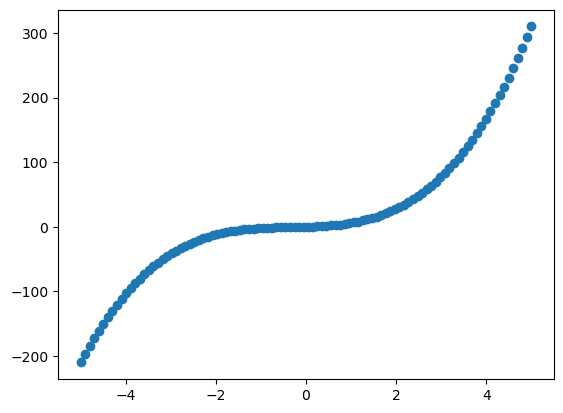

In [58]:
# Problem
true_theta = 0.5
case = 'non-linear' # 'linear': h(x)=x or 'non-linear': h(x) = x+x**2+x**3
n_obs = 1 #number of observations

# MCMC without emulator
x0 = 0 # Chain starting point
sigma2_mc =1 # MCMC proposal variance
sigma2_e=0.1 # Observation error variance
iters=5000 # Number of MCMC iterations
burn_in = int(round(0.2*iters)) #20% burn_in

# MCMC with emulator
ndim = 1 #Dimension of x
nwalkers = 2 # Number of emcee walkers (package recommends at least 2 x ndim)
p0 = np.random.normal(0,1,2) #Initial positions for walkers
p=100 #Number of training points for emulator
thin = 10 
# Emulator parameters
x_train=torch.linspace(-5,5,p) #Training point locations 
y_train = fun_h(x_train,case) #Observations (function evaluated at training points)

plt.plot(x_train.detach().numpy(),y_train.detach().numpy(),'o')

rl= -5 #lower observational bound
ru=  5 #upper observational bound

tp =100 # number of test points

x_test = torch.linspace(ru,rl,tp) #test points over full range
y_test = fun_h(x_test,case)

#Filtering methods
N= 500 # ensemble size
num_steps = [10,50,100,200,400,1000] #list of number of iterations in the Kalman methods 
X_init = np.zeros((1,N))   # Initial ensemble for all methods
X_init[0,:] = np.random.normal(0,1,N)

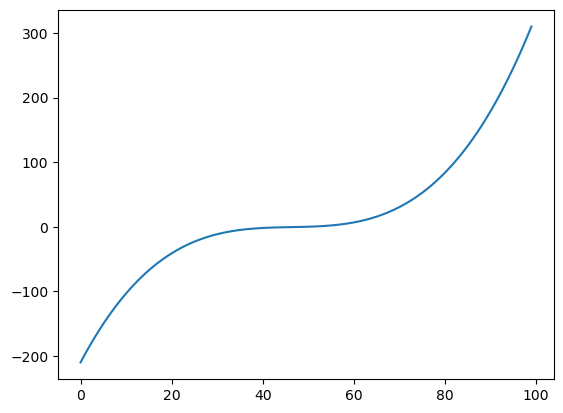

In [59]:
plt.plot(y_train)

# Training the emulator

In [60]:
emulator=GPE.ensemble(x_train[:,None],y_train[:,None],mean_func='linear') #Train emulator using GPE ensemble

0


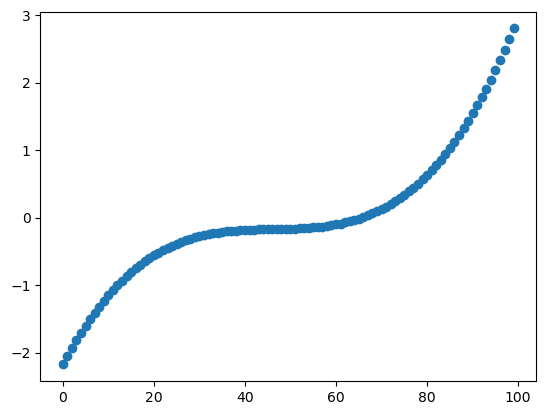

In [61]:
plt.plot(emulator.training_output_normalised.detach().numpy(),'o')

In [62]:
emulator.training_output_STD

tensor([104.3634])

# Generate observations 

In [63]:
Z = fun_h(true_theta,case) + np.sqrt(sigma2_e)*np.random.normal(size=(iters,1)) # generating a large measurement ensemble

tensor([ 2.8032,  2.6419,  2.4861,  2.3360,  2.1914,  2.0524,  1.9189,  1.7908,
         1.6676,  1.5497,  1.4373,  1.3297,  1.2269,  1.1289,  1.0359,  0.9474,
         0.8633,  0.7838,  0.7086,  0.6371,  0.5702,  0.5070,  0.4477,  0.3920,
         0.3401,  0.2912,  0.2460,  0.2041,  0.1648,  0.1289,  0.0956,  0.0648,
         0.0366,  0.0113, -0.0120, -0.0330, -0.0519, -0.0689, -0.0840, -0.0973,
        -0.1090, -0.1194, -0.1282, -0.1358, -0.1422, -0.1478, -0.1523, -0.1562,
        -0.1593, -0.1615, -0.1638, -0.1654, -0.1670, -0.1684, -0.1699, -0.1715,
        -0.1733, -0.1755, -0.1781, -0.1816, -0.1853, -0.1903, -0.1958, -0.2028,
        -0.2107, -0.2199, -0.2308, -0.2431, -0.2571, -0.2729, -0.2907, -0.3102,
        -0.3321, -0.3563, -0.3828, -0.4118, -0.4435, -0.4781, -0.5154, -0.5558,
        -0.5994, -0.6464, -0.6965, -0.7501, -0.8077, -0.8686, -0.9336, -1.0026,
        -1.0755, -1.1525, -1.2340, -1.3194, -1.4098, -1.5044, -1.6035, -1.7077,
        -1.8164, -1.9300, -2.0484, -2.17

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_69582/385316673.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta=torch.tensor(theta)[:,None]


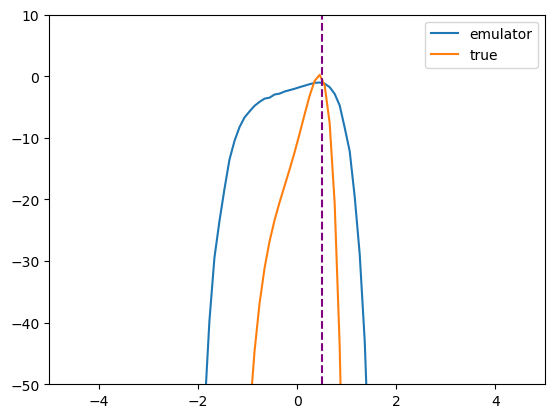

In [64]:
######################################################################
############## VERIFY THE EMULATOR LOG-LIKELIHOOD ####################
######################################################################
plt.plot(x_test,log_likelihood_emulator(Z[0],x_test,sigma2_e,emulator).T)
plt.plot(x_test,log_likelihood(Z[0],x_test,sigma2_e,fun_h,case).T)
plt.xlim([-5,5])
plt.ylim([-50,10])
plt.axvline(x=true_theta, linestyle='--',label = 'True parameter',color = 'purple')
plt.legend(['emulator','true'])

In [55]:
tensor([ 2.0759,  0.9749,  0.3093, -0.0169, -0.1302, -0.1524, -0.1965, -0.3811,
        -0.8315, -1.6515], grad_fn=<ViewBackward0>)
tensor([0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001, 0.0002, 0.0002, 0.0002,
        0.0002], grad_fn=<DiagonalBackward0_copy>)
tensor([ 309.7468,  156.2735,   63.4802,   18.0151,    2.2253,   -0.8684,
          -7.0187,  -32.7594,  -95.5417, -209.8373], grad_fn=<AddBackward0>)
tensor([3.9594, 3.4591, 3.0421, 3.0514, 2.9772, 2.9772, 3.0328, 3.0328, 3.4869,
        3.9687], grad_fn=<AddBackward0>)

SyntaxError: invalid syntax (3639459241.py, line 2)

In [56]:
#  analytical posterior mean and variance for a linear obseravtion function

if case=='linear':
    posterior_mean_mult_obs = (Z[0:n_obs].sum()/sigma2_e + x0/sigma2_mc)/(n_obs/sigma2_e + 1/sigma2_mc)
    posterior_cov_mult_obs = 1/(n_obs/sigma2_e + 1/sigma2_mc)
    

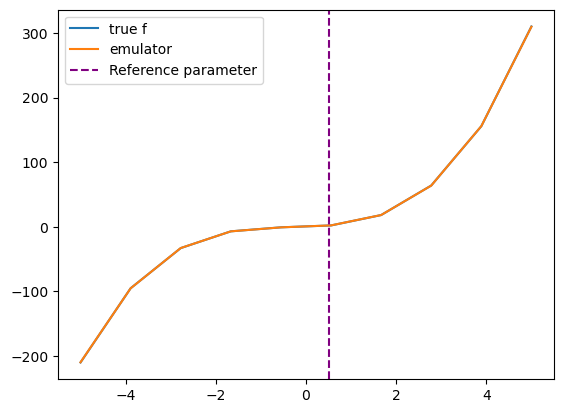

In [57]:
plt.plot(x_test,fun_h(x_test,case).detach().numpy())
plt.plot(x_test.detach().numpy(),emulator.predict(x_test).detach().numpy())
plt.axvline(x=true_theta, linestyle='--',label = 'True parameter',color = 'purple')
plt.legend(('true f','emulator','Reference parameter'))

# Run all methods and compare

acceptance rate= 7.739999999999999 %
acceptance rate= 7.82 %
acceptance rate= 8.559999999999999 %
acceptance rate= 8.02 %
acceptance rate= 7.82 %
acceptance rate= 7.88 %
Table of means 
           MCMC      EnKF  new EnKF       EKI  Reference
10    0.447264  0.416940  0.415590  0.408135        0.5
50    0.441663  0.431126  0.429924  0.431128        0.5
100   0.435281  0.434768  0.435231  0.429475        0.5
200   0.433449  0.428345  0.430039  0.430113        0.5
400   0.444853  0.436461  0.434653  0.434617        0.5
1000  0.438450  0.428917  0.433631  0.432787        0.5 
 Table of variances 
           MCMC      EnKF  new EnKF       EKI
10    0.003793  0.010546  0.009118  0.010103
50    0.003967  0.007060  0.005802  0.006143
100   0.004597  0.007428  0.005750  0.005521
200   0.004596  0.009280  0.006656  0.005401
400   0.003937  0.013024  0.005592  0.005247
1000  0.004528  0.021948  0.005702  0.005552


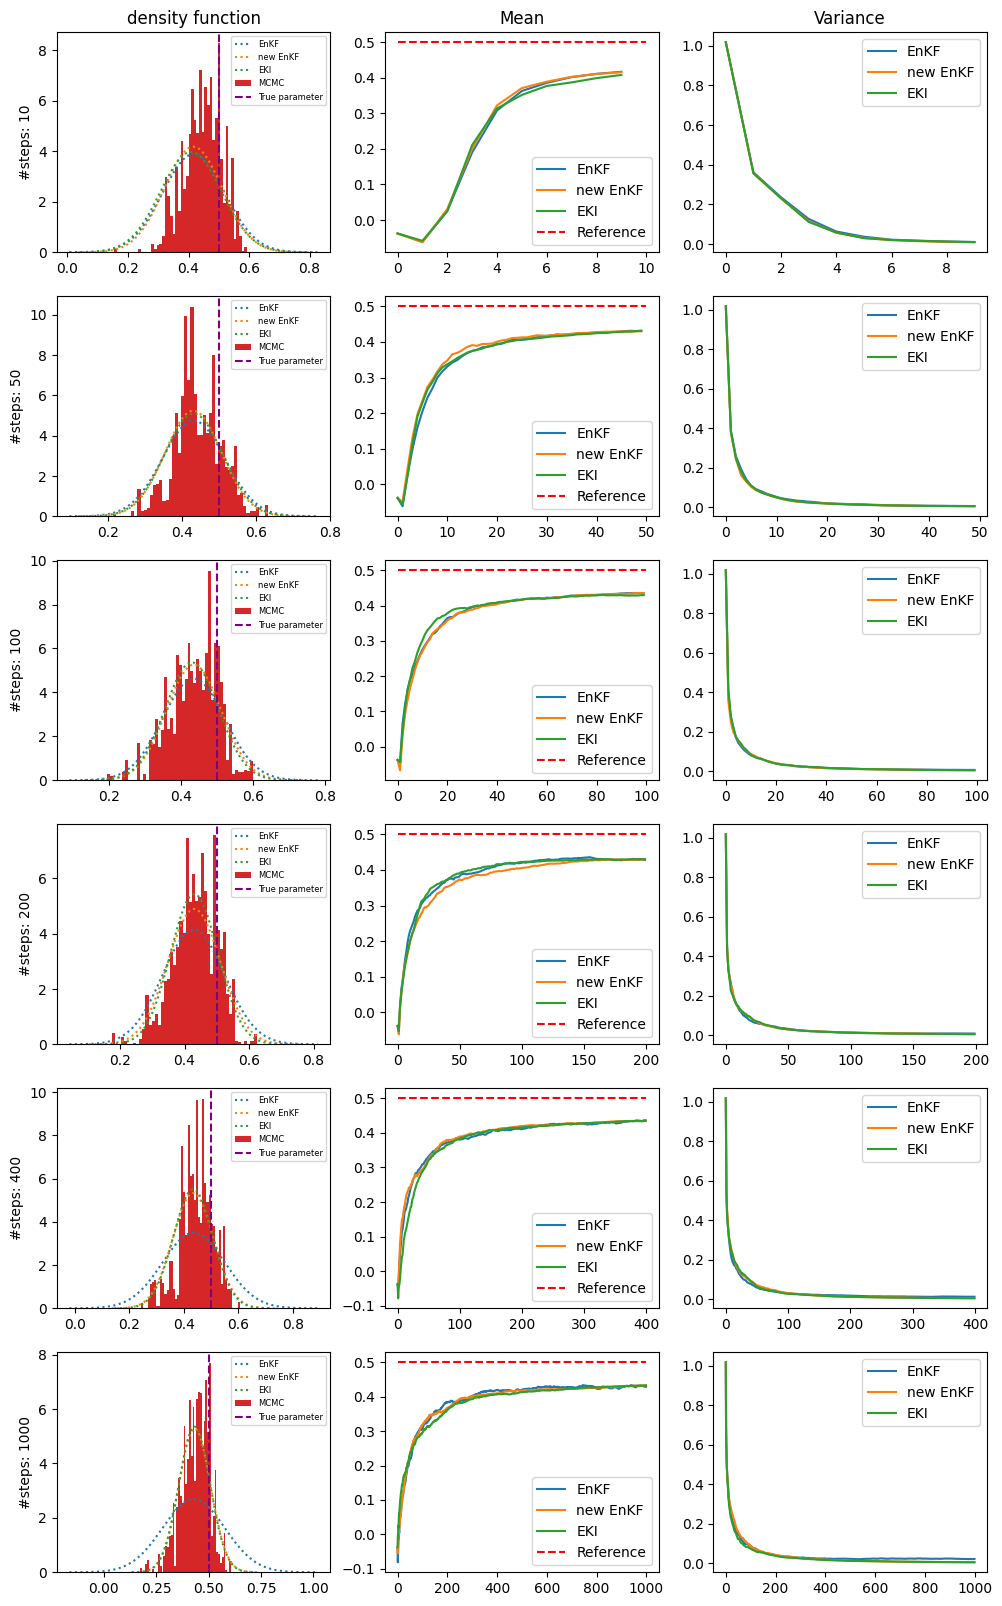

In [16]:
fig,axes = plt.subplots(len(num_steps),3,figsize = (12,20))
table_mean = {'MCMC':[],'EnKF':[],'new EnKF':[],'EKI':[],'Reference':[]}
table_var = {'MCMC':[],'EnKF':[],'new EnKF':[],'EKI':[]}
use_emulator = False #True


for i in range(len(num_steps)):
    # EnKF
    X_mean, X_var, X_sample    = calibrate_EnKF(Z,n_obs,sigma2_e,fun_h,emulator,N,num_steps[i],X_init,case,use_emulator)
    # new EnKF (without process dynamics)
    X2_mean, X2_var, X2_sample = calibrate_new_EnKF(Z,n_obs,sigma2_e,fun_h,emulator,N,num_steps[i],X_init,case,use_emulator)
    # EKI
    X3_mean,X3_var,X3_sample   = calibrate_EKI(Z,n_obs,sigma2_e,fun_h,emulator,N,num_steps[i],X_init,case,use_emulator)
    # MCMC
    X_mcmc = calibrate_MCMC(Z,n_obs,fun_h,emulator,num_steps[i],case,iters,nwalkers,ndim,log_prob_emulator_mult,sigma2_e,sigma2_mc,burn_in,thin,use_emulator)
    
    table_mean, table_var = plot_all_methods(X_mean,X_var,X2_mean,X2_var,X3_mean,X3_var,X_mcmc,fig,axes,i,table_mean, table_var,true_theta)
    for i, ax_row in enumerate(axes):
        ax_row[0].set_ylabel('#steps: {}'.format(num_steps[i]))
    
if case=='linear':
    table_mean['analytical mean'] = posterior_mean_mult_obs*np.ones(len(num_steps))
    table_var['analytical variance'] = posterior_cov_mult_obs*np.ones(len(num_steps))
    
df_mean = pd.DataFrame(table_mean)
df_var = pd.DataFrame(table_var)

# Set the index of the DataFrame
df_mean.index = num_steps
df_var.index = num_steps

print("Table of means \n",df_mean,"\n Table of variances \n",df_var)

